In [1]:
import os
# running from Root directory
os.chdir("..")

In [57]:
from connectome import calculate_cell_type_conn_matrix
from connectome_types import ClfType, SynapseDirection, m_types, cell_types
import matplotlib.pyplot as plt 
import numpy as np
clf_type_space = [e.value for e in ClfType]

In [76]:
def plot_cell_type_conn_matrix(z, labels, title, text_inside=False):
    c = plt.imshow(z, cmap ='YlOrRd') 
    plt.colorbar(c) 
    plt.title(f'{title}', fontweight ="bold") 
    
    plt.xticks(ticks=np.arange(len(labels)), labels=labels,  rotation=90)
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)

    if text_inside:
        for i in range(z.shape[0]):
            for j in range(z.shape[1]):
                plt.text(j, i, f'{z[i, j]:.2f}', ha='center', va='center', color='black')
        
    plt.show() 

In [59]:
mtype_output_mat = calculate_cell_type_conn_matrix('mtype', m_types, SynapseDirection.output)
mtype_input_mat = calculate_cell_type_conn_matrix('mtype', m_types, SynapseDirection.input)

In [60]:
celltype_output_mat = calculate_cell_type_conn_matrix('cell_type', cell_types, SynapseDirection.output)
celltype_input_mat = calculate_cell_type_conn_matrix('cell_type', cell_types, SynapseDirection.input)

In [64]:
clftype_output_mat = calculate_cell_type_conn_matrix('clf_type', clf_type_space, SynapseDirection.output)
clftype_input_mat = calculate_cell_type_conn_matrix('clf_type', clf_type_space, SynapseDirection.input)

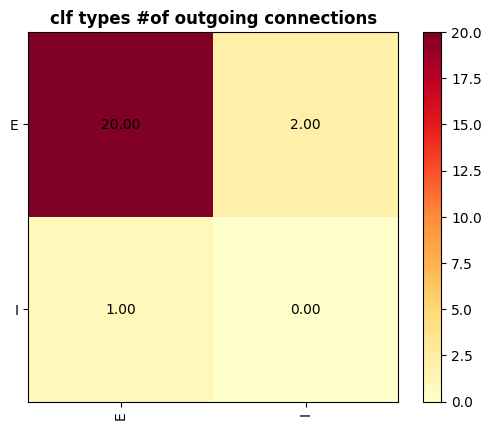

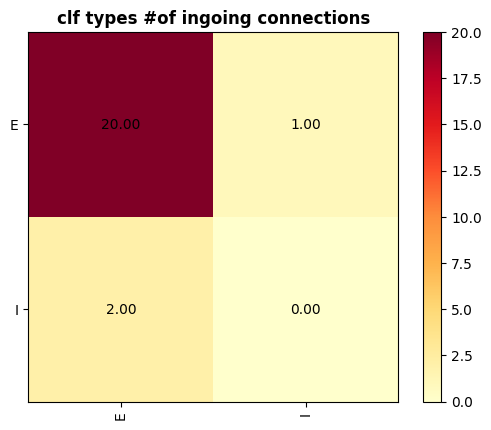

In [82]:
plot_cell_type_conn_matrix(clftype_output_mat, clf_type_space, 'clf types #of outgoing connections', True)
plot_cell_type_conn_matrix(clftype_input_mat, clf_type_space, 'clf types #of ingoing connections', True)

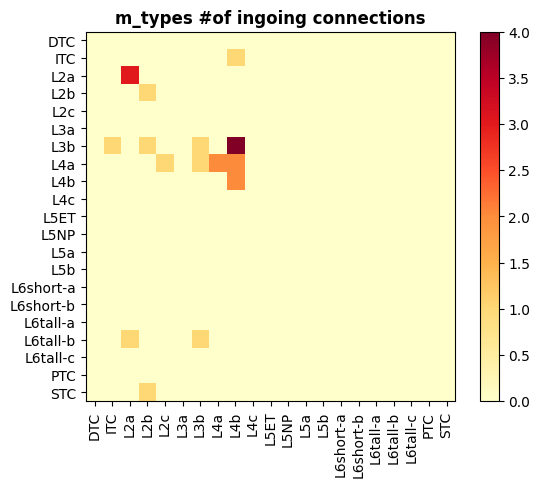

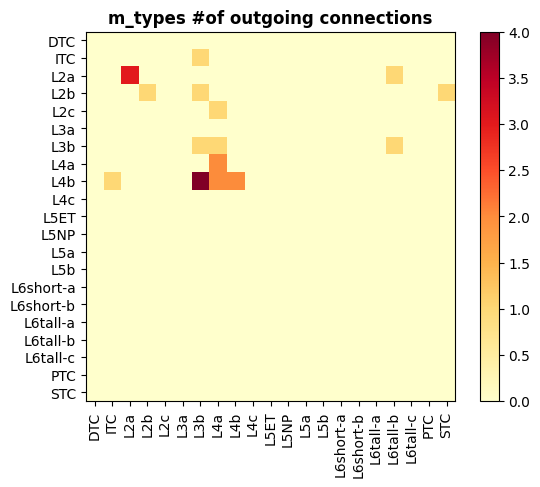

In [80]:
plot_cell_type_conn_matrix(mtype_input_mat, m_types, 'm_types #of ingoing connections')
plot_cell_type_conn_matrix(mtype_output_mat, m_types, 'm_types #of outgoing connections')

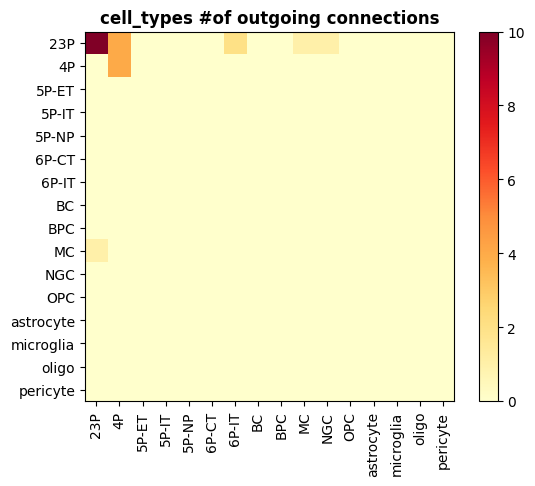

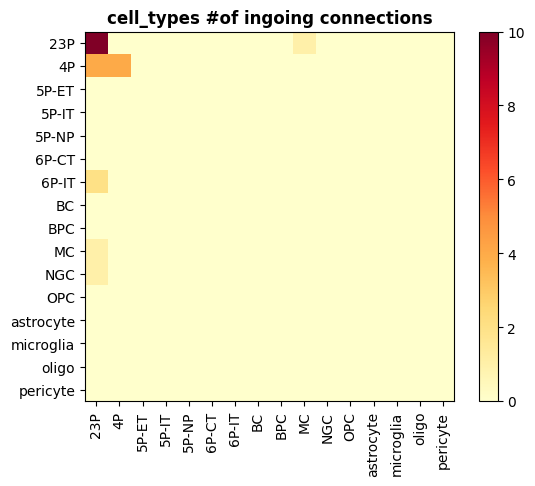

In [81]:
plot_cell_type_conn_matrix(celltype_output_mat, cell_types, 'cell_types #of outgoing connections')
plot_cell_type_conn_matrix(celltype_input_mat, cell_types, 'cell_types #of ingoing connections')